# 🧠 LSTM Prediction of Handling Duration for Service Calls

This notebook builds an LSTM model to predict the **expected handling time** (in hours) of a service request, based on encoded categorical data and momentum features.

**Includes:**
- 🧼 Data loading and cleaning  
- 📊 Feature engineering with 3-day & 7-day moving averages  
- 🔁 LSTM model training and evaluation  
- 📈 Visualization of training loss and MAE  
- ⚙️ Interactive prediction function for new requests  


In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [19]:
# Load the data
df = pd.read_csv('/content/drive/MyDrive/מדעי המחשב/שנה ג/סמסטר ב/האקתון דאטה/model 2/load_feature_final.csv')

# Drop rows with any NaN values
df.dropna(inplace=True)

# Check for NaN values and display where they occur
nan_summary = df.isna().sum()
nan_columns = nan_summary[nan_summary > 0]

if nan_columns.empty:
    print("✅ אין ערכים חסרים בקובץ!")
else:
    print("⚠️ נמצאו ערכים חסרים בעמודות הבאות:")
    print(nan_columns)
    print("שורות עם ערכים חסרים:")
    print(df[df.isna().any(axis=1)].index.tolist())


✅ אין ערכים חסרים בקובץ!


In [20]:
# Create moving averages for "משך טיפול (בשעות)"
df['moving_avg_3'] = df['משך טיפול (בשעות)'].rolling(window=3, min_periods=1).mean()
df['moving_avg_7'] = df['משך טיפול (בשעות)'].rolling(window=7, min_periods=1).mean()

# Define features and target
feature_cols = [col for col in df.columns if col not in ['משך טיפול (בשעות)', 'תאריך', 'רמת_עומס']]
X = df[feature_cols]
y = df['משך טיפול (בשעות)']

# Normalize features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Reshape input for LSTM: (samples, time_steps, features)
X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [21]:
# Build LSTM model
model = Sequential()
model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [22]:
# Train the model
history = model.fit(X_train, y_train,
                    epochs=100,
                    batch_size=64,
                    validation_split=0.2,
                    callbacks=[early_stop],
                    verbose=1)



Epoch 1/100
979/979 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 1.2047 - mae: 0.4057 - val_loss: 0.7750 - val_mae: 0.3899
Epoch 2/100
979/979 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.6708 - mae: 0.3969 - val_loss: 0.6006 - val_mae: 0.3834
Epoch 3/100
979/979 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.6175 - mae: 0.3872 - val_loss: 0.5336 - val_mae: 0.3663
Epoch 4/100
979/979 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.4954 - mae: 0.3728 - val_loss: 0.4707 - val_mae: 0.3572
Epoch 5/100
979/979 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.5056 - mae: 0.3742 - val_loss: 0.4298 - val_mae: 0.3746
Epoch 6/100
979/979 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.4060 - mae: 0.3626 - val_loss: 0.3977 - val_mae: 0.3537
Epoch 7/100
979/979 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.3970 - mae: 0.3653 - val_loss: 0.3865 - val_mae: 0.3554
Epoch 8/100
979/979 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.3733 - mae: 0.3592 - val_loss: 0.4012 - val_mae: 0.3590
Epoch 9/100
979/979 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms

In [25]:
# Evaluate
y_pred = model.predict(X_test)

# Metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2 Score: {r2:.2f}")


612/612 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
MAE: 0.31
RMSE: 0.51
R2 Score: 0.69


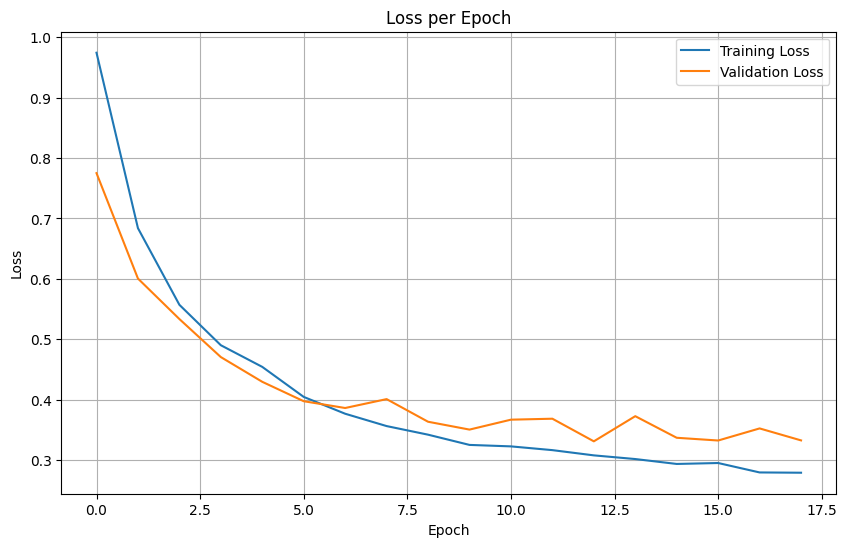

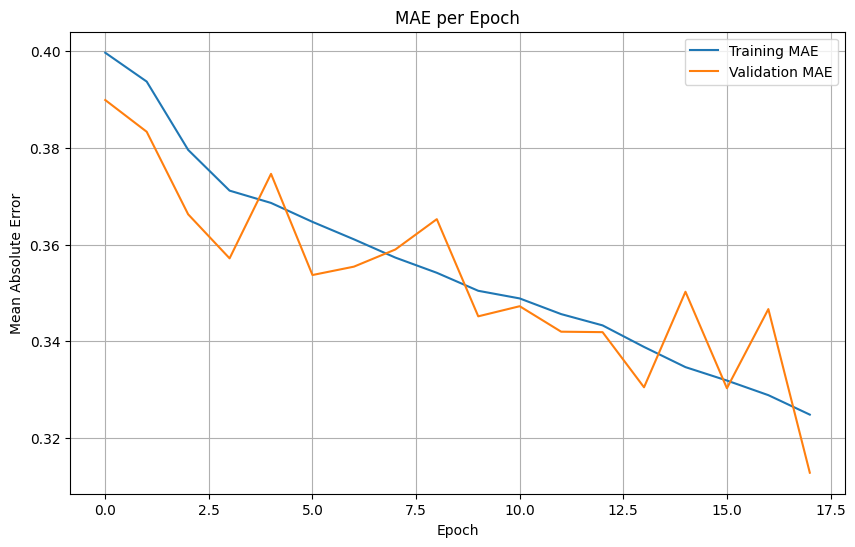

In [26]:
import matplotlib.pyplot as plt

# ציור גרף Loss
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# ציור גרף MAE (אם שמרת מדד MAE במהלך האימון)
if 'mae' in history.history:
    plt.figure(figsize=(10,6))
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title('MAE per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Absolute Error')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("⚠️ לא נשמר MAE במהלך האימון (רק Loss). אם תרצה, אפשר להוסיף את זה בעתיד לקומפילציה.")


In [27]:
def create_request(ones_list, moving_avg_3, moving_avg_7):
    """
    ones_list: רשימה של שמות הפיצ'רים שצריכים לקבל 1
    moving_avg_3: ערך ממוצע נע ל-3 ימים
    moving_avg_7: ערך ממוצע נע ל-7 ימים
    """
    # התבסס על feature_cols שהוגדרו במודל שלך
    request = {feature: 0 for feature in feature_cols}

    # עדכון הפיצ'רים שרוצים להדליק
    for feature in ones_list:
        if feature in request:
            request[feature] = 1
        else:
            print(f"⚠️ פיצ'ר {feature} לא קיים ב-feature_cols שלך.")

    # הוספת ממוצעים נעים
    request['moving_avg_3'] = moving_avg_3
    request['moving_avg_7'] = moving_avg_7

    return pd.DataFrame([request])


In [34]:
# רשימת הפיצ'רים לשים 1
features_to_one = [
    'אגף_אגף תפעול',
    'יום_שלישי',
    'חודש_5',
    'שנה_2025',
    'עומס_גבוה'
]

# יצירת הבקשה
new_request_df = create_request(features_to_one, moving_avg_3=0.5, moving_avg_7=0.7)

# נרמול
new_request_scaled = scaler.transform(new_request_df)

# התאמה למבנה של LSTM
new_request_scaled = new_request_scaled.reshape((1, 1, new_request_scaled.shape[1]))

# חיזוי
predicted_duration = model.predict(new_request_scaled)

print(f"זמן טיפול חזוי: {predicted_duration[0][0]:.2f} שעות")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
זמן טיפול חזוי: 1.45 שעות


In [32]:
features_to_one = [
    'עומס_בינוני',          # עומס נמוך
    'סוגיית מים',
    'אגף_אגף תפעול',      # אגף שמטפל בפניות פיזיות בשטח
    'יום_חמישי',          # יום לקראת סופ״ש
    'חודש_12',             # ינואר - חורף
    'שנה_2025',           # שנה עדכנית
    'חג'                  # אם נופל על חג = דחיות אפשריות
]

# ממוצעים נעים גבוהים יחסית
moving_avg_3 = 2.0   # נניח יומיים אחרונים ממוצע גבוה
moving_avg_7 = 2.5   # גם שבוע אחרון ממוצע גבוה


In [33]:
new_request_df = create_request(features_to_one, moving_avg_3, moving_avg_7)

# נרמול
new_request_scaled = scaler.transform(new_request_df)

# התאמה למבנה של LSTM
new_request_scaled = new_request_scaled.reshape((1, 1, new_request_scaled.shape[1]))

# חיזוי
predicted_duration = model.predict(new_request_scaled)

print(f"זמן טיפול חזוי: {predicted_duration[0][0]:.2f} שעות")


⚠️ פיצ'ר סוגיית מים לא קיים ב-feature_cols שלך.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
זמן טיפול חזוי: 0.65 שעות
